In [1]:
import PIL
from PIL import Image
import imagehash

import pycamhd.pycamhd as camhd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd       

def diff_letters(a,b):
    if (len(a) != len(b)):
        return -1
    else:
        return sum ( a[i] != b[i] for i in range(len(a)) )

dbcamhd = (pd.read_json('dbcamhd.json', orient="records", lines=True)).set_index("filename", drop = False)
dbcamhd.tail()  

fileIDs = []
avgHash = []
dHash = []
pHash = []
wHash = []

In [2]:
from dask import delayed, compute

@delayed
def delayed_get_frame(filename, frame_number):
    frame = camhd.get_frame(filename, frame_number)
    return Image.fromarray(frame)

@delayed
def delayed_average_hash(image):
    return imagehash.average_hash(image)

@delayed
def delayed_phash(image):
    return imagehash.phash(image)

@delayed
def delayed_dhash(image):
    return imagehash.dhash(image)

@delayed
def delayed_whash(image):
    return imagehash.whash(image)

In [3]:
filenames = list(dbcamhd.filename[(dbcamhd.frame_count > 2000) & (dbcamhd.frame_count < 30000) & (dbcamhd.deployment == 3)])
len(filenames)

4622

In [4]:
for filename in filenames[0:1]:
    frameTotal = dbcamhd.frame_count[filename]
    #print(frameTotal)
    timestamp = dbcamhd.timestamp[filename]
    frames =  range(0,frameTotal,10)
    #print(frames)
    
    for i in frames:        
        im = delayed_get_frame(filename, i)
        avg = delayed_average_hash(im)
        p = delayed_phash(im)
        d = delayed_dhash(im)
        w = delayed_whash(im)
        
        avgHash.append(avg.hash.flatten())
        pHash.append(p.hash.flatten())
        dHash.append(d.hash.flatten())
        wHash.append(w.hash.flatten())
        #wHash.append(w.hash)

In [5]:
from dask_kubernetes import KubeCluster
from dask.distributed import Client

cluster = KubeCluster();
cluster.scale(30);

In [6]:
cluster

In [7]:
client = Client(cluster)
client

Client Scheduler: tcp://10.244.5.24:44141 Dashboard: /user/al3623/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 120.00 GB


In [8]:
%%time
wHashList = compute(*wHash)

CPU times: user 48.2 s, sys: 5.22 s, total: 53.4 s
Wall time: 1min 43s


In [10]:
%%time
pHashList = compute(*pHash)

CPU times: user 43.8 s, sys: 4.76 s, total: 48.6 s
Wall time: 1min 36s


In [12]:
%%time
dHashList = compute(*dHash)

CPU times: user 43.6 s, sys: 4.87 s, total: 48.5 s
Wall time: 1min 40s


In [15]:
%%time
avgHashList = compute(*avgHash)

CPU times: user 43.4 s, sys: 4.4 s, total: 47.8 s
Wall time: 1min 32s


In [23]:
npwHash = np.array(wHashList).T
npwHash.shape

(64, 2518)

In [24]:
nppHash = np.array(pHashList).T
nppHash.shape

(64, 2518)

In [25]:
npdHash = np.array(dHashList).T
npdHash.shape

(64, 2518)

In [26]:
npaHash = np.array(avgHashList).T
print(npaHash.shape)

(64, 2518)


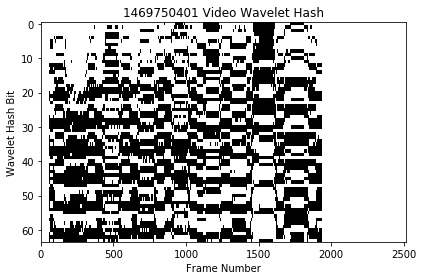

In [41]:
plt.xlabel('Frame Number')
plt.ylabel('Wavelet Hash Bit')
plt.title(str(timestamp) + " Video Wavelet Hash")
plt.tight_layout()
plt.imshow(npwHash,cmap="Greys",aspect="auto")
plt.savefig("w_bin_im_" + str(timestamp) + ".png", dpi=300)

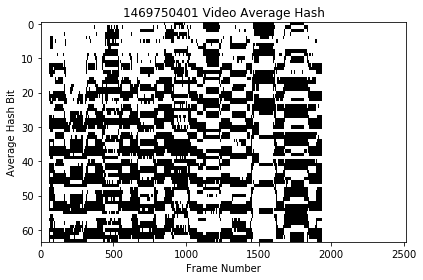

In [42]:
plt.xlabel('Frame Number')
plt.ylabel('Average Hash Bit')
plt.title(str(timestamp) + " Video Average Hash")
plt.tight_layout()
plt.imshow(npaHash,cmap="Greys",aspect="auto")
plt.savefig("avg_bin_im_" + str(timestamp) + ".png", dpi=300)

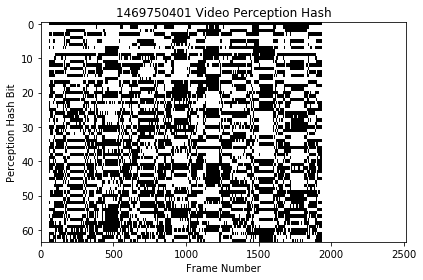

In [43]:
plt.xlabel('Frame Number')
plt.ylabel('Perception Hash Bit')
plt.title(str(timestamp) + " Video Perception Hash")
plt.tight_layout()
plt.imshow(nppHash,cmap="Greys",aspect="auto")
plt.savefig("p_bin_im_" + str(timestamp) + ".png", dpi=300)

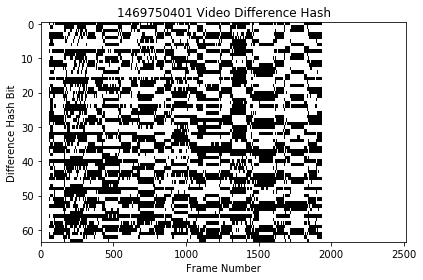

In [44]:
plt.xlabel('Frame Number')
plt.ylabel('Difference Hash Bit')
plt.title(str(timestamp) + " Video Difference Hash")
plt.tight_layout()
plt.imshow(npdHash,cmap="Greys",aspect="auto")
plt.savefig("d_bin_im_" + str(timestamp) + ".png", dpi=300)

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots();
fig.set_size_inches(14, 6);
fig.frameon = False
hb = ax.hexbin(frames, wHashList[1135:], vmin=0, vmax=1, bins='log', linewidths=0.25,
  gridsize=(225,4500), mincnt=1, cmap=plt.cm.BuPu)
fig.colorbar(hb)
ax.set_ylim([0, 8000])
ax.set_xlim([frames[0],frames[-1]])
ax.yaxis.grid(True)
ax.xaxis.grid(True)